# Coursework 1: Gaussian processes
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/cw/coursework1.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/). This version adapted by Damon Wischik._

In this assignment you will use Gaussian process modelling.
This coursework uses the Python package [`sklearn.gaussian_process`](http://scikit-learn.org/stable/modules/gaussian_process.html) which is the rough equivalent of the [GPML](http://www.gaussianprocess.org/gpml/code/matlab/doc/) package for MATLAB. See the appendix at the end of this document for a walkthrough.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. Complete listings are
unnecessary. The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two.

In [1]:
# Standard imports for scientific and engineering work in Python:
import numpy as np                      # MATLAB-style matrix and vector manipulation
import matplotlib.pyplot as plt         # MATLAB-style plotting
import matplotlib                       # for more control over plotting
import scipy.io                         # some useful data input-output routines
import sklearn.gaussian_process as gp   # Gaussian process modeling
import requests                         # for retrieving data over the web
import io                               # also used for importing data
import pandas as pd                     # data-science-style dataset manipulation
from sklearn.model_selection import ParameterGrid
from math import exp
import time
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots
import random
from scipy.spatial.distance import pdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])

# Configure matplotlib to show its output right in the notebook


## Question (a)

Load data from `https://teachingfiles.blob.core.windows.net/probml/cw1a.mat`. Consider a Gaussian process with a squared exponential covariance function,
```
ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ),
```
and minimize the negative log marginal likelihood starting with hyperparameters `λ=np.exp(-1)`, `ν=1`, `σ=1`. Show the 95% predictive error bars. Comment on the predictive error bars and the optimized hyperparameters.


Initial kernel:
1**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)
Kernel with optimized hyperparameters:
0.897**2 * RBF(length_scale=0.128) + WhiteKernel(noise_level=0.0139)
Log marginal likelihood:
-11.899004246586806
Optimal hyperparameters:
[0.8046 0.1282 0.0139]


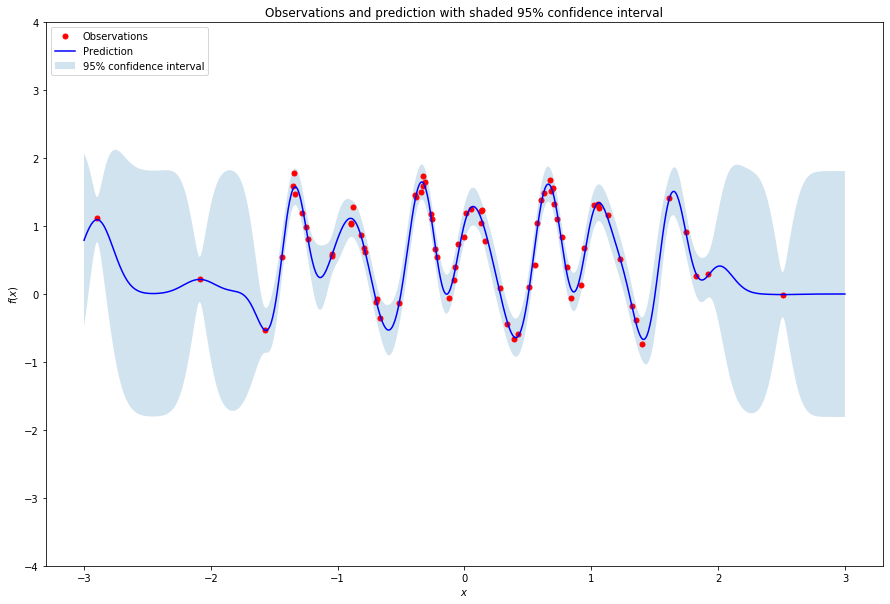

In [2]:
# To import a .mat file from a URL:
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1a.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']

print("")
# Hyperparameters:
l = np.exp(-1)
v = 1
sigma = 1
# Construkt kernel:
kernel1 = v**2*gp.kernels.RBF(length_scale = l) + gp.kernels.WhiteKernel(noise_level=sigma)
# Create model:
model1 = gp.GaussianProcessRegressor(kernel=kernel1)
# Learn the hyperparameters that minimize the negative log marginal likelihood:
# Print kernel with initial parameters
print("Initial kernel:")
print(model1.kernel)
model1.fit(x, y)
# Print kernel with optimized parameters
print("Kernel with optimized hyperparameters:")
print(model1.kernel_)
# Print and store log marginal likelihood
print("Log marginal likelihood:")
print(model1.log_marginal_likelihood(model1.kernel_.theta))
logML = model1.log_marginal_likelihood(model1.kernel_.theta)
# Print log of optimal hyperparameters
print("Optimal hyperparameters:")
print(np.round(np.exp(np.array(model1.kernel_.theta)),4))
hyparam = model1.kernel_.theta

# Values of x where we want to make a prediction
x_pred = np.linspace(-3, 3, 1000)
# Predicting, returning y values and corresponding standard deviation
y_pred, sigma = model1.predict(x_pred[..., np.newaxis], return_std=True)


# Plot the function, the prediction and the 95% confidence interval based on
plt.figure(figsize=[15, 10])
plt.plot(x, y, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(x_pred.squeeze(), y_pred.squeeze()-2*sigma, y_pred.squeeze()+2*sigma, alpha=.2, label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-4, 4)
plt.legend(loc='upper left')
plt.title("Observations and prediction with shaded 95% confidence interval")
plt.show()


### Answer (a):
We see that the optimized parameters for the given initial values are v = 0.8046, lamda = 0.128 and sigma = 0.0139.
The 95% confidence interval shows us that the model is more certain in areas with more data points, as expected.
A (local) optimum for the log marginal likelihood was found to be -11.899004246586806.

## Question (b)

Show that by initializing the hyperparameters differently, you can ﬁnd a different local optimum for the hyperparameters. Try a range of values. Show the fit. Explain what is going on. Which fit is best, and why? 

Log marginal likelihood:
-78.3373
Corresponding hyperparameters:
l: 0.553 v: 99843.2338 sigma: 0.4451


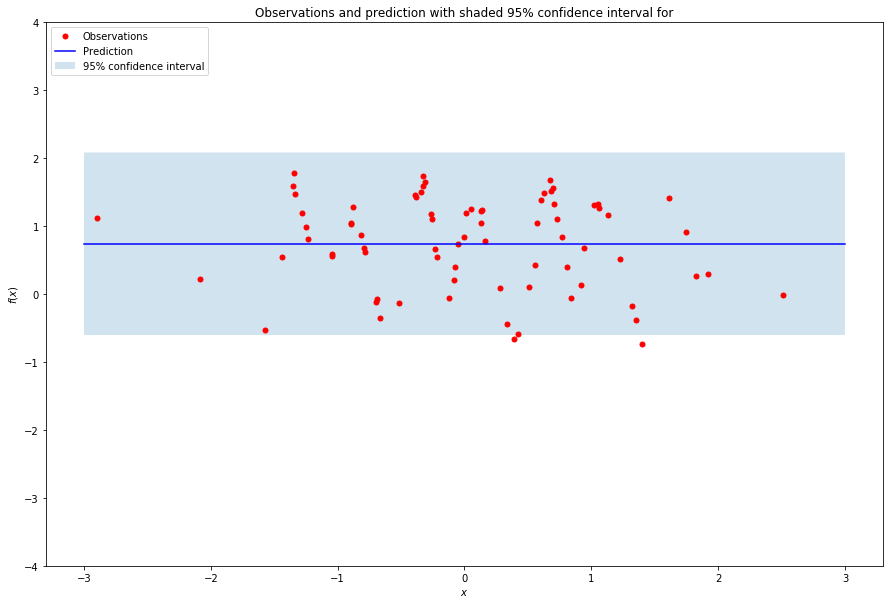

Log marginal likelihood:
-78.2202
Corresponding hyperparameters:
l: 0.4844 v: 8.0424 sigma: 0.4397


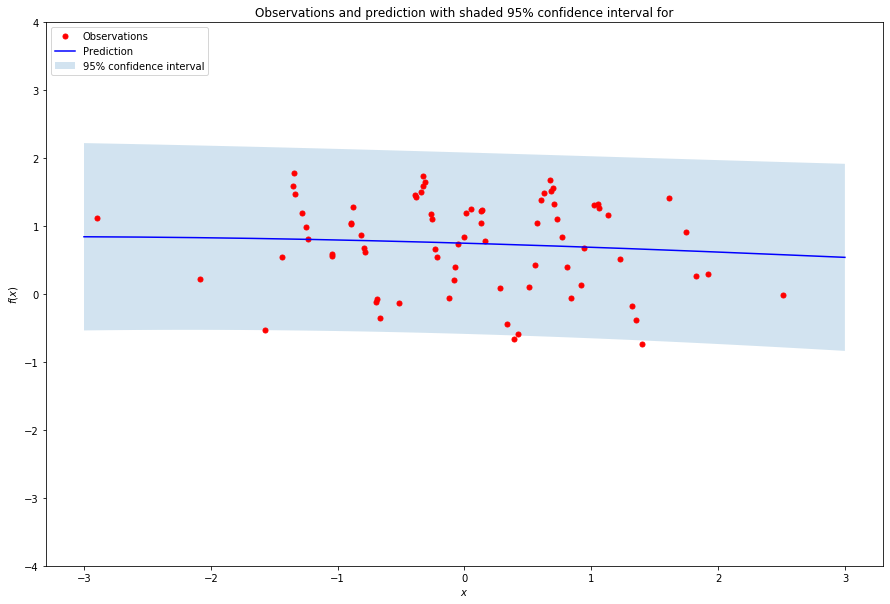

Log marginal likelihood:
-106.3493
Corresponding hyperparameters:
l: 0.0919 v: 0.0 sigma: 0.9062


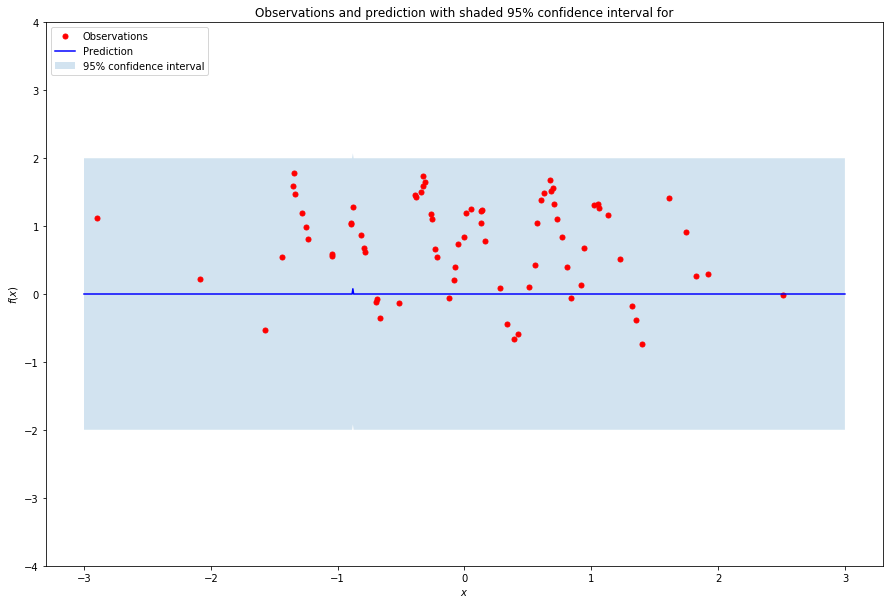

The different optimums found through parameter search
[ -11.899   -78.3373  -78.2202 -106.3493]


In [3]:
# Executing a grid search over a set of initial hyperparameters:
param_grid = {'l': np.linspace(0.05, 3, 10), 'v': np.linspace(0.1, 2, 10), 'sigma': np.linspace(0.001, 3, 10)}
# Store the already found log marginal likelihood
LML = np.array([round(logML,4)])
# Store the already found local optimal hyperparams 
hyperparams = np.array([hyparam])
for g in ParameterGrid(param_grid):
    # Construkt kernel:
    kernel = g['v']**2*gp.kernels.RBF(length_scale = g['l']) + gp.kernels.WhiteKernel(noise_level=g['sigma'])
    # Create model:
    model = gp.GaussianProcessRegressor(kernel=kernel)
    model.fit(x,y)
    # Check if local optimum for the log marginal likelihood is different from the previous ones
    if round(model.log_marginal_likelihood(model.kernel_.theta),4) not in LML:
        # Appnd to log marginal likelihood array
        LML = np.concatenate((LML, [round(model.log_marginal_likelihood(model.kernel_.theta),4)]))
        # Store hyperparameters
        hyperparams = np.vstack((hyperparams,model.kernel_.theta))
        # Predicting, returning y values and corresponding standard deviation
        y_pred, sigma = model.predict(x_pred[..., np.newaxis], return_std=True)
        # Print log marginal likelihood:
        print("Log marginal likelihood:")
        print(round(model.log_marginal_likelihood(model.kernel_.theta),4))
        print("Corresponding hyperparameters:")
        print("l: "+ str(round(exp(model.kernel_.theta[0]),4)) + " v: "+ str(round(exp(model.kernel_.theta[1]),4)) + " sigma: "+ str(round(exp(model.kernel_.theta[2]),4)))
        # Plot the function, the prediction and the 95% confidence interval based on
        plt.figure(figsize=[15, 10])
        plt.plot(x, y, 'r.', markersize=10, label='Observations')
        plt.plot(x_pred, y_pred, 'b-', label='Prediction')
        plt.fill_between(x_pred.squeeze(), y_pred.squeeze()-2*sigma, y_pred.squeeze()+2*sigma, alpha=.2, label='95% confidence interval')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.ylim(-4, 4)
        plt.legend(loc='upper left')
        plt.title("Observations and prediction with shaded 95% confidence interval for")
        plt.show()
print("The different optimums found through parameter search")
print(LML)


### Answer (b):
We see from the parameter search above that there are three other local optimums for the log marginal likelihood (lml). All of them have a lower lml value than the one found initially, making it likely that -11.899 is the global optimum for this keernel. From the plot and hyperparameters we can see that the global optimum has low noise and a short length-scale while the local optimums have high noise and long length-scales. This means that the other models try to explain everything as noise and therefore no longer needs the covariance. The best model, however, can almost exactly follow the observations and is therefore not so dependent of the noise level.

## Question (c)

Train instead a GP with a periodic covariance function, using [`gp.kernels.ExpSineSquared`](http://scikit-learn.org/stable/modules/gaussian_process.html#exp-sine-squared-kernel). Show the fit. Comment on the
behaviour of the error-bars, compared to your fit from (a). Do you think the data generating mechanism
was really periodic? Why, why not?

Initial kernel:
ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)
Kernel with optimized hyperparameters:
ExpSineSquared(length_scale=0.957, periodicity=0.999) + WhiteKernel(noise_level=0.012)
Log marginal likelihood:
35.206571071420285
Optimal hyperparameters:
l: 0.9574 v: 0.9988 sigma: 0.012


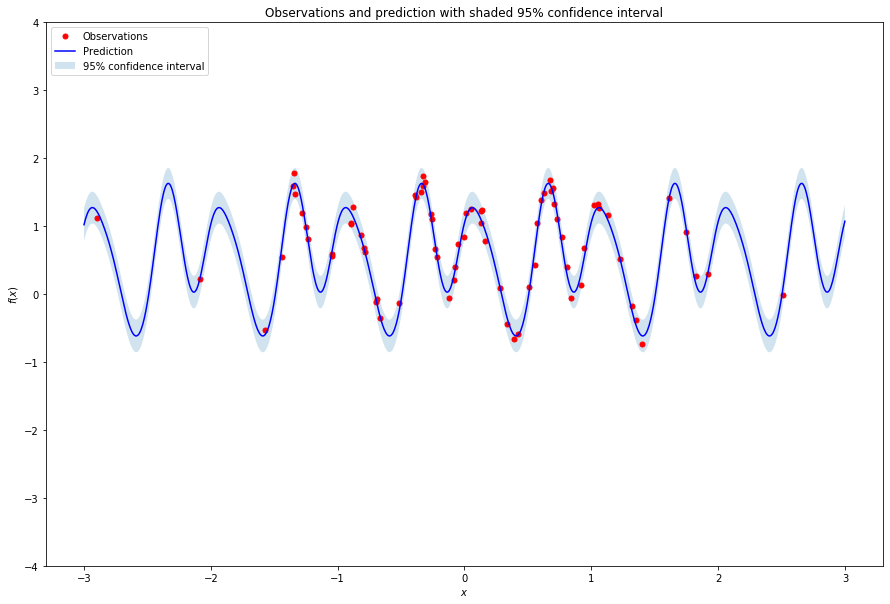

In [4]:
# GP with periodic covariance function:
# Hyperparameters (only length_scale and periodicity, default is one for both):
l = 1
# Noise level
sigma = 1
# Construkt kernel:
kernel2 = gp.kernels.ExpSineSquared(length_scale = 1) + gp.kernels.WhiteKernel(noise_level=sigma)
# Create model:
model2 = gp.GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer = 10)
# Learn the hyperparameters that minimize the negative log marginal likelihood:
# Print kernel with initial parameters
print("Initial kernel:")
print(model2.kernel)
model2.fit(x, y)
# Print kernel with optimized parameters
print("Kernel with optimized hyperparameters:")
print(model2.kernel_)
# Print and store log marginal likelihood
print("Log marginal likelihood:")
print(model2.log_marginal_likelihood(model2.kernel_.theta))
logML = model2.log_marginal_likelihood(model2.kernel_.theta)
# Print log of optimal hyperparameters
print("Optimal hyperparameters:")
print("l: "+ str(round(exp(model2.kernel_.theta[0]),4)) + " v: "+ str(round(exp(model2.kernel_.theta[1]),4)) + " sigma: "+ str(round(exp(model2.kernel_.theta[2]),4)))


# Values of x where we want to make a prediction
x_pred = np.linspace(-3, 3, 1000)
# Predicting, returning y values and corresponding standard deviation
y_pred, sigma = model2.predict(x_pred[..., np.newaxis], return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
plt.figure(figsize=[15, 10])
plt.plot(x, y, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(x_pred.squeeze(), y_pred.squeeze()-2*sigma, y_pred.squeeze()+2*sigma, alpha=.2, label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-4, 4)
plt.legend(loc='upper left')
plt.title("Observations and prediction with shaded 95% confidence interval")
plt.show()

### Answer (c):
From the figure above it is clear that the new model has a better fit than the one used in (a). This is also shown by the substantial increase in the log marginal likelihood, now ~ 35 compared to ~ -12. With this finding it is reasonable to assume that the underlying mechanism generating the data is periodic.


## Question (d)

Generate 200 noise-free data points at `x = np.linspace(-5,5,200)` from a Gaussian process with the following
covariance function: 
```
1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) 
    * gp.kernels.RBF(length_scale=np.exp(2)))
```
Don’t add noise to the function values, i.e. don't add `gp.kernels.WhiteKernel()` to the kernel.
Using `GaussianProcessRegressor.sample_y()`, plot some sample functions. Explain their behaviour.

_The choice of kernel dictates what output are likely. By looking at sample functions, 
you gain experience of the expressive power of Gaussian process models. Ultimately, you should be able to look at a scatterplot and
know straight away what type of kernel would be a good fit._

In [6]:
%matplotlib
# Construct kernel:
kernel3 = 1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) * gp.kernels.RBF(length_scale=np.exp(2))
# Create model:
model3 = gp.GaussianProcessRegressor(kernel=kernel3, n_restarts_optimizer = 10)
# x values for sampling
x = np.linspace(-5,5,200)
# Generate some sample functions
y_samples1 = model3.sample_y(x[..., np.newaxis],3)

# Multiple line plot
plt.figure(figsize=[10, 6])
plt.plot(x, y_samples1[:,0])
plt.plot(x, y_samples1[:,1])
plt.plot(x, y_samples1[:,2])
plt.legend(['y1', 'y2', 'y3'], loc='upper left')
plt.title("Periodic and squared exponential")
plt.show()

# Comparing it to a purely periodic model:
# Construct kernel:
kernel4 = 1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) 
model4 = gp.GaussianProcessRegressor(kernel=kernel4, n_restarts_optimizer = 10)
# Generate some sample functions
y_samples2 = model4.sample_y(x[..., np.newaxis],3)
# Multiple line plot
plt.figure(figsize=[10, 6])
plt.plot(x, y_samples2[:,0])
plt.plot(x, y_samples2[:,1])
plt.plot(x, y_samples2[:,2])
plt.legend(['y1', 'y2', 'y3'], loc='upper left')
plt.title("Purely periodic model")
plt.show()

# Comparing it to a purely squared exponential model:
# Construct kernel:
kernel5 = gp.kernels.RBF(length_scale=np.exp(2))
model5 = gp.GaussianProcessRegressor(kernel=kernel5, n_restarts_optimizer = 10)
# Generate some sample functions
y_samples3 = model5.sample_y(x[..., np.newaxis],3)
# Multiple line plot
plt.figure(figsize=[10, 6])
plt.plot(x, y_samples3[:,0])
plt.plot(x, y_samples3[:,1])
plt.plot(x, y_samples3[:,2])
plt.legend(['y1', 'y2', 'y3'], loc='upper left')
plt.title("Purely squared exponential")
plt.show()

Using matplotlib backend: MacOSX


### Answer (d):
We see from the samples of the three different kernels above that they all have their distinct way of representing data. The squared exponential (RBF) function is substantially smoother than the periodic covariance function (as expected). The hybrid version, the product between the two, does not seem to be significantly different from the purely periodic one. Multyplying with the RBF functions acts more as a scalar multiplication, scaling the periodic function.

## Question (e)

Load `https://teachingfiles.blob.core.windows.net/probml/cw1e.mat`. This data has two-dimensional input and scalar output. Visualise the data, e.g. using the code snippets in the appendix.
Consider two different Gaussian process models of the data, one using covariance function
`RBF(length_scale=[l1,l2])`
and the other using the sum of two such `RBF` terms. (Make sure to break symmetry, e.g. by choosing the initial hyperparameters randomly.)

Compare the two models. How do the data fits compare? How do the marginal likelihoods compare? What is your interpretation? Which of the two is better?

> When `length_scale` is a list, the `RBF` kernel uses separate length-scale parameters for each dimension of the input space. In GPML it is known as 'Squared Exponential with Automatic Relevance Determination', `covSEard`. It is a useful tool to learn which inputs are important for predictions: if length-scales are short, inputs are very important, and when they grow very long (compared to the spread of the data), the corresponding inputs will be largely ignored.

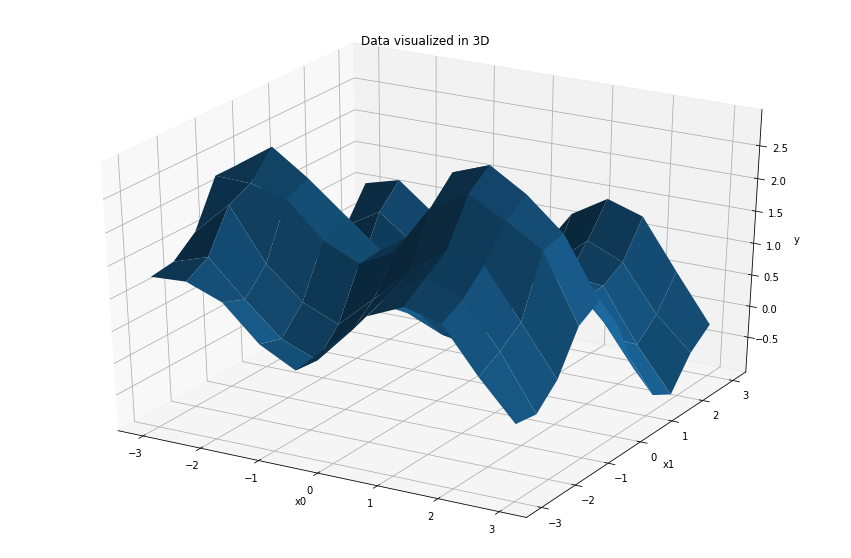

Optimized kernels:
Model 1: RBF(length_scale=[1.47, 1.25]) + WhiteKernel(noise_level=0.0104)
Model 2: RBF(length_scale=[1.4, 1e+05]) + RBF(length_scale=[1e+05, 1.06]) + WhiteKernel(noise_level=0.00958)
Log marginal likelihood:
Model 1: 19.02091649164808
Model 2: 65.88298292781565


In [7]:
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1e.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']


# Reshape the data to be in array form
X = x[:,0].reshape((11,11))
Y = x[:,1].reshape((11,11))
Z = y.reshape((11,11))


# Optionally: use `%matplotlib notebook` to make the plots interactive.
# Get axes for a 3d plot, and then plot the surface
axes = plt.figure(figsize=[15, 10]).gca(projection='3d')
axes.plot_surface(X, Y, Z)
axes.set_xlabel('x0')
axes.set_ylabel('x1')
axes.set_zlabel('y')
plt.title("Data visualized in 3D")
plt.show()

# Initial hyperparameters:
l1 = np.exp(-1)
l2 = np.exp(-1)
sigma = 1
# Construct kernel 1:
kernel6 = gp.kernels.RBF(length_scale = [l1,l2]) + gp.kernels.WhiteKernel(noise_level=sigma)
# Construct kernel 2:
kernel7 = gp.kernels.RBF(length_scale = [l1,l2]) + gp.kernels.RBF(length_scale = [l1,l2]) + gp.kernels.WhiteKernel(noise_level=sigma)
# Construct kernel 3:
#kernel8 = gp.kernels.RBF(length_scale = l1) + gp.kernels.RBF(length_scale = l2) + gp.kernels.WhiteKernel(noise_level=sigma)
# Create model1:
model6 = gp.GaussianProcessRegressor(kernel=kernel6, n_restarts_optimizer = 20)
# Create model1:
model7 = gp.GaussianProcessRegressor(kernel=kernel7, n_restarts_optimizer = 20)
# Create model1:
#model8 = gp.GaussianProcessRegressor(kernel=kernel8, n_restarts_optimizer = 10)
model6.fit(x,y)
model7.fit(x,y)
#model8.fit(x,y)
print("Optimized kernels:")
print("Model 1: " + str(model6.kernel_))
print("Model 2: " + str(model7.kernel_))
#print("Model 3: " + str(model8.kernel_))
print("Log marginal likelihood:")
print("Model 1: " + str(model6.log_marginal_likelihood(model6.kernel_.theta)))
print("Model 2: " + str(model7.log_marginal_likelihood(model7.kernel_.theta)))
#print("Model 3: " + str(model8.log_marginal_likelihood(model8.kernel_.theta)))

# Generate random x values for comparing prediction:
#x_pred = np.round(np.random.uniform(-3,3,x.shape),2)

# Generate z values with respect to X and Y to see difference in fit.
Z1 = model6.predict(x, return_std=True)
Z2 = model7.predict(x, return_std=True)
#Z3 = model8.predict(x, return_std=True)


# Heatmaps
# Model 1
#plt.figure()
#plt.imshow(Z1[0].reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
#plt.xlabel('x0')
#plt.ylabel('x1')
#plt.colorbar()
#plt.title("Model 1")
#plt.show()
# Model 2
#plt.figure()
#plt.imshow(Z2[0].reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
#plt.xlabel('x0')
#plt.ylabel('x1')
#plt.colorbar()
#plt.title("Model 2")
#plt.show()
# Model 3
#plt.figure()
#plt.imshow(Z3[0].reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
#plt.xlabel('x0')
#plt.ylabel('x1')
#plt.colorbar()
#plt.title("Model 3")
#plt.show()



### Answer (e):
I compare two different kernels.

1) Single RBF kernel given a list of two length-scales + noise.

2) The sum of two of the RBF kernels used in 1) + noise.

The optimised log marginal likelihoods shows that Model 2 is substantially better. Heatmaps are used to visualize the fit, but no difference is found. If we take a closer look on the optimised lenght-scales of the second model we see that for the first term, l2 is extremely high, and for the second term, l1 is extremely high. When the length-scales are given as a list, the RBF uses seperate length-scales for seperate dimensions. This means that in the case of model 2 we get one kernel that refers to the first dimension and another for the second dimension, resulting in a sum of two exponentials. Model 1 on the other hand, using only one kernel given a list of two length-scales, results in a product of two exponentials. It could be so that the two kernels fit the data equally good, but that the second kernel generates less complex functions. This leads to model 2 being better, since the marginal likelihood is a combination of data fit and complexity penalty.


- Comment: By using "n_restarts_optimizer = 10" I ensure that the optimization is restarted with random hyperparameters as requested in the question.





## Question (f)

Load `https://teachingfiles.blob.core.windows.net/probml/twoseries.csv`. This data consists of two time series, where $t$ is time, $k$ is the index of the series, and $y$ is the output. 
The data has two-dimensional input, but the second dimension is categorical rather than numerical, so it doesn't make sense to use the RBF kernel. Instead,
consider the model
$$
Y_{t,k} = Z_t + E_k + \operatorname{Normal}(0,\sigma^2)
$$
where $Z_t$ is a shared underlying RBF Gaussian process, and $E_1$ and $E_2$ are independent $\operatorname{Normal}(0,\rho^2)$ offsets, giving
$$
\operatorname{Cov}(Y_{t,k}, Y_{t',k'}) = \nu^2 \exp \Bigl( -\frac{(t-t')^2}{2\ell^2}\Bigr) + \rho^2 \delta_{k k'} + \sigma^2 \delta_{t t'}\delta_{k k'}.
$$
Implement a kernel for this model, fit it, and plot your predicted values for the two time series.

In [10]:
twoseries = pd.read_csv('https://raw.githubusercontent.com/damonjw/probml/master/data/twoseries.csv')
t,k,y = twoseries['t'].values, twoseries['k'].values, twoseries['y'].values
x = np.vstack((t,k)).T
y = y.reshape(-1,1)

In [11]:
# Define new kernels:

from scipy.spatial.distance import cdist, pdist, squareform  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])


class CustomConstantKernel1(gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):
 
    def __init__(self, constant_value=1.0, constant_value_bounds=(1e-5, 1e5)):
        self.constant_value = constant_value
        self.constant_value_bounds = constant_value_bounds

    @property
    def hyperparameter_constant_value(self):
        return gp.kernels.Hyperparameter(
            "constant_value", "numeric", self.constant_value_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):

        X = X[:,0]
        X = X.reshape(-1,1)
        X = np.atleast_2d(X)
        if Y is None:
            Y = X
        elif eval_gradient:
            raise ValueError("Gradient can only be evaluated when Y is None.")
        else:
            Y = Y[:,0]
            Y = Y.reshape(-1,1)
            Y = np.atleast_2d(Y)

        K = np.full((X.shape[0], Y.shape[0]), self.constant_value,
                    dtype=np.array(self.constant_value).dtype)
        if eval_gradient:
            if not self.hyperparameter_constant_value.fixed:
                return (K, np.full((X.shape[0], X.shape[0], 1),
                                   self.constant_value,
                                   dtype=np.array(self.constant_value).dtype))
            else:
                return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K

    def diag(self, X):
       
        return np.full(X.shape[0], self.constant_value,
                       dtype=np.array(self.constant_value).dtype)

    def __repr__(self):
        return "{0:.3g}**2".format(np.sqrt(self.constant_value))
    
class CustomConstantKernel2(gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):
 
    def __init__(self, constant_value=1.0, constant_value_bounds=(1e-5, 1e5)):
        self.constant_value = constant_value
        self.constant_value_bounds = constant_value_bounds

    @property
    def hyperparameter_constant_value(self):
        return gp.kernels.Hyperparameter(
            "constant_value", "numeric", self.constant_value_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):

        X = np.atleast_2d(X)
        if Y is None:
            Y = X
        elif eval_gradient:
            raise ValueError("Gradient can only be evaluated when Y is None.")

        k_1 = X[:,1]
        k_2 = Y[:,1]
        # Construct kronecker delta matrix for kk':
        delta_kk = np.zeros((k.shape[0],k.shape[0]))

        for i, k_ in enumerate(list(k_1)):
            for j, k_prime in enumerate(list(k_2)):
                if k_ == k_prime:
                    delta_kk[i,j] = 1
        
        K = np.full((X.shape[0], Y.shape[0]), self.constant_value,
                    dtype=np.array(self.constant_value).dtype)*delta_kk
        if eval_gradient:
            if not self.hyperparameter_constant_value.fixed:
                return (K, np.full((X.shape[0], X.shape[0], 1),
                                   self.constant_value,
                                   dtype=np.array(self.constant_value).dtype))
            else:
                return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K

    def diag(self, X):
       
        return np.full(X.shape[0], self.constant_value,
                       dtype=np.array(self.constant_value).dtype)

    def __repr__(self):
        return "{0:.3g}**2".format(np.sqrt(self.constant_value))

class CustomWhiteKernel(gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):

    def __init__(self, noise_level=1.0, noise_level_bounds=(1e-5, 1e5)):
        self.noise_level = noise_level
        self.noise_level_bounds = noise_level_bounds

    @property
    def hyperparameter_noise_level(self):
        return gp.kernels.Hyperparameter(
            "noise_level", "numeric", self.noise_level_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):

        X = np.atleast_2d(X)
        k_1 = X[:,1]
        k_2 = X[:,1]
        # Construct kronecker delta matrix for kk':
        delta_kk = np.zeros((k.shape[0],k.shape[0]))

        for i, k_ in enumerate(list(k_1)):
            for j, k_prime in enumerate(list(k_2)):
                if k_ == k_prime:
                    delta_kk[i,j] = 1
                    
        if Y is not None and eval_gradient:
            raise ValueError("Gradient can only be evaluated when Y is None.")

        if Y is None:
            K = self.noise_level * np.eye(X.shape[0])*delta_kk
            if eval_gradient:
                if not self.hyperparameter_noise_level.fixed:
                    return (K, self.noise_level
                            * np.eye(X.shape[0])[:, :, np.newaxis])
                else:
                    return K, np.empty((X.shape[0], X.shape[0], 0))
            else:
                return K
        else:
            return np.zeros((X.shape[0], Y.shape[0]))

    def diag(self, X):

        return np.full(X.shape[0], self.noise_level,
                       dtype=np.array(self.noise_level).dtype)

    def __repr__(self):
        return "{0}(noise_level={1:.3g})".format(self.__class__.__name__,
                                                 self.noise_level)
    

class CustomRBF(gp.kernels.StationaryKernelMixin, gp.kernels.NormalizedKernelMixin, gp.kernels.Kernel):

    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def anisotropic(self):
        return np.iterable(self.length_scale) and len(self.length_scale) > 1

    @property
    def hyperparameter_length_scale(self):
        if self.anisotropic:
            return gp.kernels.Hyperparameter("length_scale", "numeric",
                                  self.length_scale_bounds,
                                  len(self.length_scale))
        return gp.kernels.Hyperparameter(
            "length_scale", "numeric", self.length_scale_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        
        X = X[:,0]
        X = X.reshape(-1,1)
        X = np.atleast_2d(X)
        length_scale = gp.kernels._check_length_scale(X, self.length_scale)
        if Y is None:
            dists = pdist(X / length_scale, metric='sqeuclidean')
            K = np.exp(-.5 * dists)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            Y = Y[:,0]
            Y = Y.reshape(-1,1)
            Y = np.atleast_2d(Y)
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            dists = cdist(X / length_scale, Y / length_scale,
                          metric='sqeuclidean')
            K = np.exp(-.5 * dists)

        if eval_gradient:
            if self.hyperparameter_length_scale.fixed:
                # Hyperparameter l kept fixed
                return K, np.empty((X.shape[0], X.shape[0], 0))
            elif not self.anisotropic or length_scale.shape[0] == 1:
                K_gradient = \
                    (K * squareform(dists))[:, :, np.newaxis]
                return K, K_gradient
            elif self.anisotropic:
                # We need to recompute the pairwise dimension-wise distances
                K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 \
                    / (length_scale ** 2)
                K_gradient *= K[..., np.newaxis]
                return K, K_gradient
        else:
            return K

    def __repr__(self):
        if self.anisotropic:
            return "{0}(length_scale=[{1}])".format(
                self.__class__.__name__, ", ".join(map("{0:.3g}".format,
                                                   self.length_scale)))
        else:  # isotropic
            return "{0}(length_scale={1:.3g})".format(
                self.__class__.__name__, np.ravel(self.length_scale)[0])


In [13]:
# Construct kernel:
kernel = CustomConstantKernel1()*CustomRBF() + CustomConstantKernel2() + CustomWhiteKernel()
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 20)
model.fit(x,y)
print(model.kernel_)



/Users/jonastjomsland/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.15012487, -0.00067183,  0.20249847,  0.09635147]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/jonastjomsland/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.02496894e-01, -3.12899120e-08,  1.91069251e-01, -1.15287657e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 132, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


1.29**2 * CustomRBF(length_scale=0.104) + 1.41**2 + CustomWhiteKernel(noise_level=0.202)


In [14]:
%matplotlib
# t values for prediction:
t_pred = np.linspace(-3,3,100)
x_pred1 = np.vstack((t_pred,np.ones(t_pred.shape[0]))).T
x_pred2 = np.vstack((t_pred,2*np.ones(t_pred.shape[0]))).T

# Predicting, returning y values and corresponding standard deviation
y_pred1, sigma1 = model.predict(x_pred1, return_std=True)
y_pred2, sigma2 = model.predict(x_pred2, return_std=True)


# Plot the function, the prediction and the 95% confidence interval based on
plt.figure(figsize=[17, 8])
plt.plot(t, y, 'r.', markersize=10, label='Observations')
plt.plot(t_pred, y_pred1, label='Prediction')
plt.plot(t_pred, y_pred2, label='Prediction')
plt.fill_between(t_pred.squeeze(), y_pred1.squeeze()-2*sigma1, y_pred1.squeeze()+2*sigma1, alpha=.2, label='95% confidence interval')
plt.fill_between(t_pred.squeeze(), y_pred2.squeeze()-2*sigma2, y_pred2.squeeze()+2*sigma2, alpha=.2, label='95% confidence interval')
plt.xlabel('t')
plt.ylabel('y')
plt.ylim(-5, 4)
plt.legend(loc='upper left')
plt.title("Observations and prediction with shaded 95% confidence interval")
plt.show()

Using matplotlib backend: MacOSX


# Appendix

## Gaussian processes in Python

Here is a simple example of how to use `sklearn.gaussian_process`. For full details, see the [documentation](http://scikit-learn.org/stable/modules/gaussian_process.html).

Let's consider a simple Gaussian process model: a prior on the space of Gaussian processes, with mean 0, and with covariance function
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr)
$$
(this function is called `RBF` in `sklearn.gaussian_process` and `covSEiso` in GPML). Suppose that the data model is  
$$
p(y\:|\:x,f) \sim
\operatorname{Normal}\bigl(f(x), \sigma^2 I\bigr)
$$
where $x$ and $y$ are vectors and $f(x)$ means $(f(x_1),\dots,f(x_n))$. In this model, $\nu$, $\ell$ and $\sigma$ are hyperparameters. Another way to write out this entire model is with a single covariance function,
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr) + \sigma^2 \delta_{x x'}.
$$

In the `gaussian_process` package, a Gaussian process model is specified by a _kernel_ object. (Kernel is another name for covariance function.) The package has a [library of kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels), each implemented as a Python class, and we can create composite kernels by adding together and multiplying kernel objects.

In [28]:
l = np.exp(-1)
ν = 0.5
σ = 1
kernel1 = ν**2 * gp.kernels.RBF(length_scale=l) + gp.kernels.WhiteKernel(noise_level=σ)
kernel1

0.5**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)

To extract parameters from a kernel, use `get_params()`. You can also use `set_params` to set the parameters for a kernel.

In [29]:
kernel1.get_params()

{'k1': 0.5**2 * RBF(length_scale=0.368),
 'k1__k1': 0.5**2,
 'k1__k1__constant_value': 0.25,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2': RBF(length_scale=0.368),
 'k1__k2__length_scale': 0.36787944117144233,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k2': WhiteKernel(noise_level=1),
 'k2__noise_level': 1,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

Machine learning functions are implemented via the class `GaussianProcessRegressor`, which is initialized with a kernel object. It has methods for learning hyperparameters and making predictions. We can access a model's kernel with `GaussianProcessRegressor.kernel`.

In [30]:
model1 = gp.GaussianProcessRegressor(kernel=kernel1)
model1.kernel

0.5**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)

To learn hyperparameters, use `GaussianProcessRegressor.fit(x,y)`. It requires the parameters to be arrays with one row per observation. In the example below we start with one-dimensional input and output, so we have to reshape them to be column vectors. We can access the fitted kernel, and thence the fitted parameters, with `model.kernel_`.

In [31]:
# Training data
x = np.array([0.57650, 0.43504, 0.76607, -0.78369, -1.27129, -0.66034, 1.18100, 
              0.25929, 0.50898, -0.73703, 0.83023, 1.60078, -0.34655, -0.68073, 
              -1.21480, -0.55955, -1.28229, 0.85388, 0.73265, -0.75330])
y = np.array([ 0.96948, 1.08384, 0.62050, -0.65940, 0.54944, -0.88911, -0.37886,
              0.77166, 0.97753, -0.75901, 0.76003, -1.13327, -0.74600, -0.99293,
              0.60169, -0.98088, 0.55333, 0.60247, 0.99501, -0.83345])

model1.fit(x[..., np.newaxis], y[..., np.newaxis])
model1.kernel_


0.901**2 * RBF(length_scale=0.53) + WhiteKernel(noise_level=0.00852)

To make predictions with a fitted model, call `GaussianProcessRegressor.predict(x)`. As before, `x` should be a column vector.

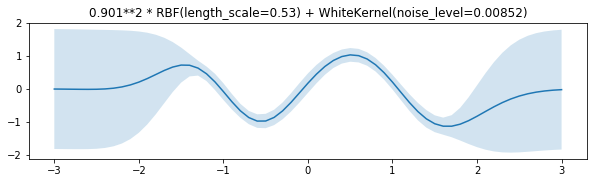

[0.90545155 0.90534144 0.90504181 0.90428806 0.90253598 0.89877396
 0.89131186 0.87763092 0.85442114 0.81792833 0.76465955 0.69237042
 0.60113188 0.49420751 0.37852979 0.26486796 0.16871807 0.1131091
 0.1096445  0.12303154 0.12612495 0.11733819 0.10557251 0.10011112
 0.10248933 0.10848354 0.11620993 0.1265148  0.13815272 0.14653951
 0.14719794 0.13915872 0.12587825 0.11341338 0.10613601 0.10342839
 0.1021866  0.10133362 0.10215798 0.10562196 0.1111809  0.11811615
 0.12581179 0.131956   0.13253851 0.12705196 0.12914936 0.16662902
 0.24638761 0.35212302 0.46684971 0.5773294  0.67423686 0.75240185
 0.81057257 0.85053736 0.87586529 0.89065449 0.89860241 0.90253147
 0.90431831]


In [34]:
# New values of x where we want to make a prediction
newx = np.linspace(-3, 3, 61)
μ,σ = model1.predict(newx[..., np.newaxis], return_std=True)

# Plot the output.
# squeeze() is a numpy function that turns column vectors into simple 1d vectors.
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.fill_between(newx, μ.squeeze()-2*σ, μ.squeeze()+2*σ, alpha=.2)
    plt.plot(newx, μ.squeeze())
    #plt.scatter(x, y, color='black')
    plt.title(model1.kernel_)
plt.show()
print(σ)

## Custom kernels

If there is no standard kernel that captures the covariance function we want, it's easy to implement a custom kernel. 
Below is a reimplementation of the RBF kernel, which has covariance function
$$
k(x, x') = \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr).
$$
The main method is `__call__`, which computes a covariance matrix, 
and is invoked by
```
k = MyRBFKernel(length_scale=2.718)
x = np.array([1,2,4])[:, np.newaxis]
y = np.array([1.5,3])[:, np.newaxis]
k(x,y)     # returns a matrix m_{i,j} = kernel(x_i, y_j)
```
The `__init__` constructor should accept arguments for each hyperparameter,
and there should be `hyperparameter_X` properties that describe each hyperparameter.
The simple implementation below requires $x\in\mathbb{R}$, but the [source code for the built-in RBF kernel](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/gaussian_process/kernels.py) allows multidimensional features $x\in\mathbb{R}^d$ with anisotropic length-scale $\ell\in\mathbb{R}^d$.
It is also more efficient.

In [9]:
from scipy.spatial.distance import cdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])

class MyRBFKernel(gp.kernels.Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def hyperparameter_length_scale(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("length_scale", 'numeric', self.length_scale_bounds, 1)

    def is_stationary(self):
        return True
    
    def diag(self, X):
        # The code, as originally posted, returned self(X,X), which is incorrect.
        return np.diagonal(self(X, X))

    def __call__(self, X, Y=None, eval_gradient=False):
        
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y) if Y is not None else X
        
        if X.ndim != 2 or Y.ndim != 2 or X.shape[1] != 1 or Y.shape[1] != 1:
            raise ValueError("Features must be scalars")
        length_scale = np.squeeze(self.length_scale).astype(float)
        
        if length_scale.ndim != 0:
            raise ValueError("Length scale must be a number")
            
        if nu.ndim != 0:
            raise ValueError("Nu must be a number")
            
        if rho.ndim != 0:
            raise ValueError("Rho must be a number")
            
        if sigma.ndim != 0:
            raise ValueError("Sigma must be a number")
        
        K = np.exp(-0.5 * cdist(X, Y, metric='sqeuclidean') / length_scale**2)
        
        if not eval_gradient:
            return K

        # The gradient is with respect to log-transformed parameters.
        # I.e. if length_scale=exp(x), then eval_gradient should return d/dx.
        # If there are multiple hyperparameters, return an array with one
        # column for each non-fixed hyperparameter, sorted alphabetically
        # by hyperparameter name.
        if self.hyperparameter_length_scale.fixed:
            K_gradient = np.empty((len(X), len(Y), 0))
        else:
            K_gradient = K * cdist(X, Y, metric='sqeuclidean') / length_scale**2
        return K, K_gradient[:, :, np.newaxis]

    def __repr__(self):
        return f"RBF(length_scale={self.length_scale:.3g})"

## Plotting a function of two variables

Here are some ways we might plot the data from part (e).

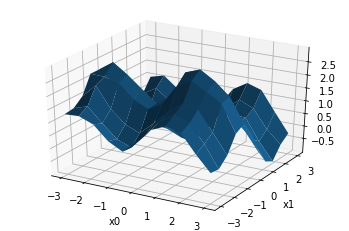

In [12]:
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots

# Reshape the data to be in array form
X = x[:,0].reshape((11,11))
Y = x[:,1].reshape((11,11))
Z = y.reshape((11,11))

# Optionally: use `%matplotlib notebook` to make the plots interactive.
# Get axes for a 3d plot, and then plot the surface
axes = plt.figure().gca(projection='3d')
axes.plot_surface(X, Y, Z)
axes.set_xlabel('x0')
axes.set_ylabel('x1')
plt.show()

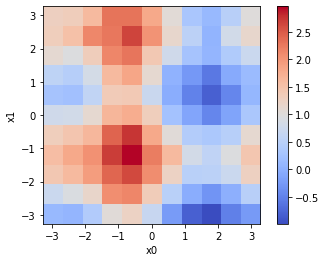

In [13]:
# A heatmap
plt.imshow(y.reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('x0')
plt.ylabel('x1')
plt.colorbar()
plt.show()